# Config file of an example using LSTM-KF-RL on a synthetic time series
This file include 
1. synthetic data generation
2. training BDLM-LSTM model with hyper-parameters-free AR
3. check if the BDLM-LSTM model is correct (LSTM, AR, AA)
4. generate time series for RL agent training
5. train RL agents
6. evaluate the performance of RL agents

In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import csv
import pandas as pd
import copy

from tqdm import tqdm
from datetime import datetime, timedelta
from src.RL_functions.generate_synthetic_time_series import *
from examples.data_loader import TimeSeriesDataloader
from pytagi import Normalizer as normalizer
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm
import pytagi.metric as metric
from pytagi import Normalizer

from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.BDLM_trainer import BDLM_trainer
from src.RL_functions.regime_change_detection_RLKF import regime_change_detection_RLKF

## 1. Generate synthetic time series with Kernel regression

In [2]:
components = ['acceleration', 'kernel', 'ar']
hyperparameters = {'acceleration': {'process_error_var': 0.0, 'constant_LA_process_error': 0.0 },
                   'kernel': {'period': 52, 'kernel_length': 0.5, 'sigma_KR0': 0, 'sigma_KR1': 0, 'n_cp':10},
                   'ar': {'phi': 0.7, 'process_error_var': 0.2**2},
                #    'ar': {'phi': 0.75, 'process_error_var': 0**2},
                   'observation': {'error': 1e-20}}
x_init = {'mu': np.array([0.294, 0.001, 0, 0, -0.35, -0.25, 1.90, 2.81, -0.03, 0.30, -0.35, 1.70, 0.10, -0.15, -0.05]), \
          'var': np.diag([1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 6.36E-05])}

total_time_steps = int(52*40+1)
time_step_interval = 7
time_covariates = ['week_of_year']
obs_file_paths = ['data/synthetic_ts/syn_train_obs.csv', 'data/synthetic_ts/syn_val_obs.csv', 'data/synthetic_ts/syn_test_obs.csv']
date_file_paths=['data/synthetic_ts/syn_train_datetime.csv', 'data/synthetic_ts/syn_val_datetime.csv', 'data/synthetic_ts/syn_test_datetime.csv']
np.random.seed(2024)

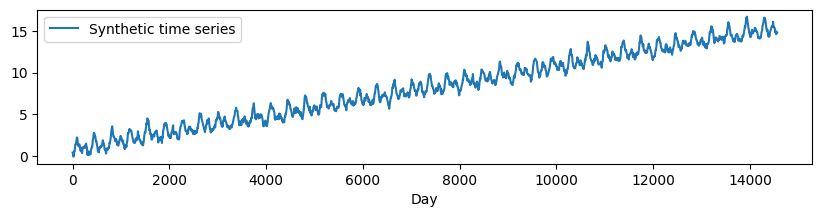

In [3]:
# generate synthetic time series
syn_ts = generate_one_synthetic_time_series(components = components,\
                                      time_step_interval = time_step_interval, \
                                      hyperparameters = hyperparameters,\
                                      num_steps = total_time_steps, \
                                      x_init = x_init,\
                                      # insert_anomaly = True,\
                                      # anomaly_timesteps = [500+hyperparameters['kernel']['period'] * 5],\
                                      # anomaly_LT=[0.003])
                                      insert_anomaly = False)
syn_ts.plot()
syn_ts.export_to_csv(indices_train_val_test=[hyperparameters['kernel']['period'] * 4, hyperparameters['kernel']['period'] * 5, -1],
                     observation_file_paths = obs_file_paths,
                     datetime_file_paths=date_file_paths,
                     start_datetime=datetime(2005, 11, 6, 12, 0, 0))
val_datetime_values = syn_ts.get_validation_datetime_values()

## 2. Train BDLM
The components are AA + AR + LSTM. The AR component here learns automatically the phi_AR and sigma_AR

### BDLM training configuration

In [4]:
num_epochs: int = 50
batch_size: int = 1
sigma_v: float = 1E-12

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

Epoch 50/50| mse:    0.04: 100%|██████████| 50/50 [01:23<00:00,  1.66s/it]


#############
MSE           :  1.04
Log-likelihood: -11.31


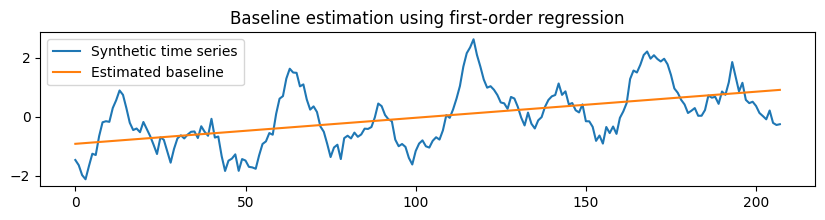

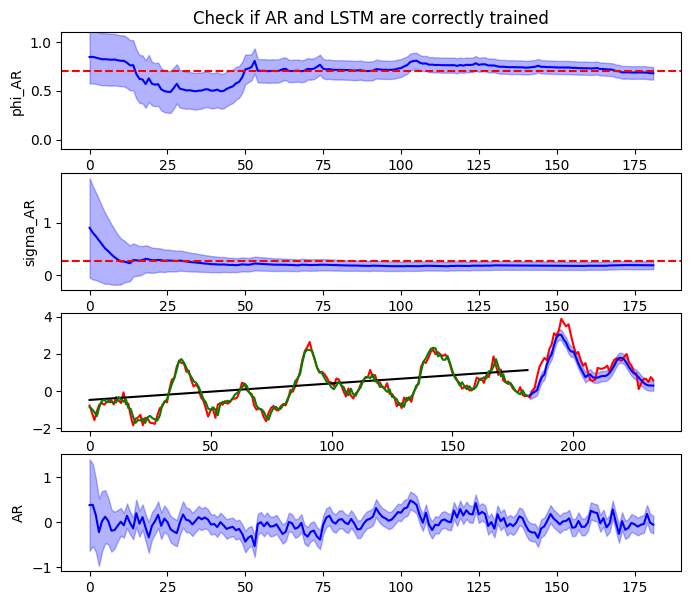

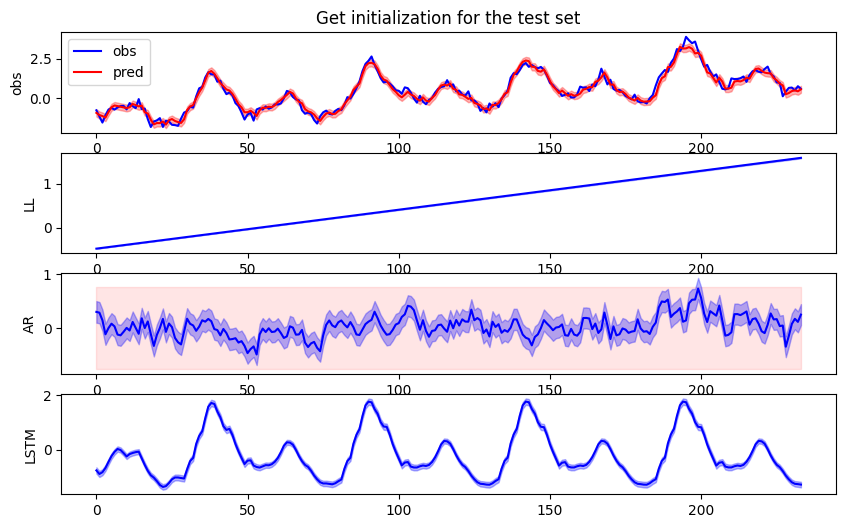

In [5]:
BDLM = BDLM_trainer(num_epochs=num_epochs,
                    batch_size=batch_size,
                    sigma_v=sigma_v,
                    output_col=output_col,
                    num_features=num_features,
                    input_seq_len=input_seq_len,
                    output_seq_len=output_seq_len,
                    seq_stride=seq_stride)
BDLM.load_datasets(obs_file_paths, date_file_paths, time_covariates)
BDLM.estimate_initial_baseline(plot=True)
BDLM.train(plot=True, true_phiAR = hyperparameters['ar']['phi'], true_SigmaAR = hyperparameters['ar']['process_error_var'])
BDLM.save_LSTM_model(path = './saved_param/syn/lstm_syn.pth')
# Store the smoothed initial value from training + validation sets, and remove the phi_AR hidden state
trainset_init_z = np.delete(BDLM.model.smoothed_init_z, 3).reshape(-1, 1)
trainset_init_Sz = np.delete(BDLM.model.smoothed_init_Sz, 3, axis=0)
trainset_init_Sz = np.delete(trainset_init_Sz, 3, axis=1)

LSTM_net, init_mu_lstm, init_var_lstm, init_z, init_Sz, \
last_seq_obs, last_seq_datetime, last_lstm_x = BDLM.get_testing_model_initials(initial_z=trainset_init_z,
                                                                                initial_Sz=trainset_init_Sz,
                                                                                val_datetime_values=val_datetime_values,
                                                                                plot=True)

## 3. Check if AA is correct

/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM/src/RL_functions/BDLM_trainer.py:478: RuntimeWarning: invalid value encountered in sqrt
  ax0.fill_between(np.arange(len(mu_preds_norm)), np.array(mu_preds_norm) - np.sqrt(var_preds_norm), np.array(mu_preds_norm) + np.sqrt(var_preds_norm), color='red', alpha=0.3)
/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM/src/RL_functions/BDLM_trainer.py:487: RuntimeWarning: invalid value encountered in sqrt
  ax2.fill_between(np.arange(len(mu_lstm)), np.array(mu_lstm) - np.sqrt(var_lstm), np.array(mu_lstm) + np.sqrt(var_lstm), color='blue', alpha=0.3, label='±1 SD')
/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM/src/RL_functions/BDLM_trainer.py:491: RuntimeWarning: invalid value encountered in sqrt
  ax3.fill_between(np.arange(len(mu_AR)), np.array(mu_AR) - np.sqrt(var_AR), np.array(mu_AR) + np.sqrt(var_AR), color='blue', alpha=0.3, label='±1 SD')


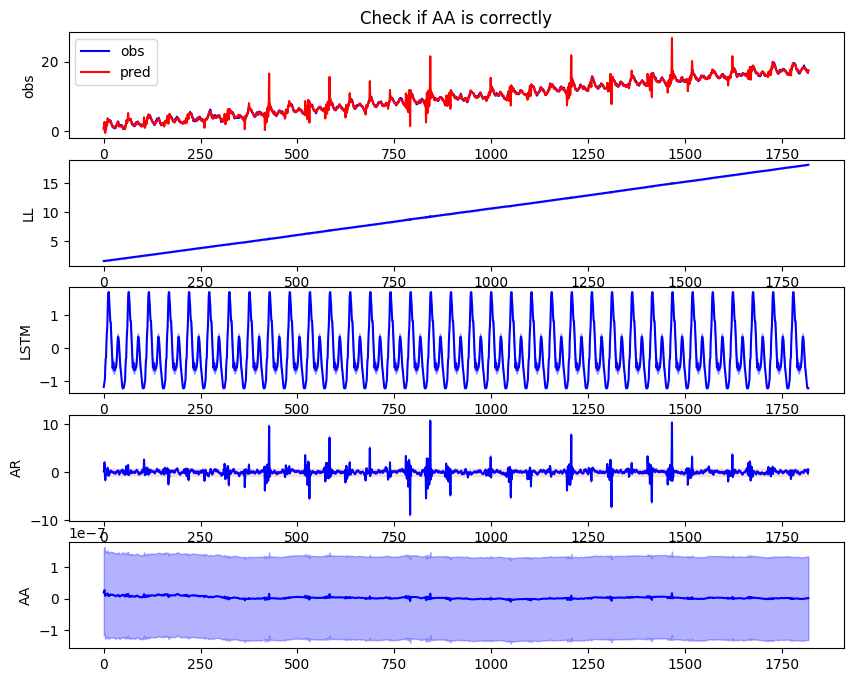

In [6]:
BDLM.check_AA(plot = True)

## 4. generate time series for RL agent training

100%|██████████| 200/200 [06:55<00:00,  2.08s/it]


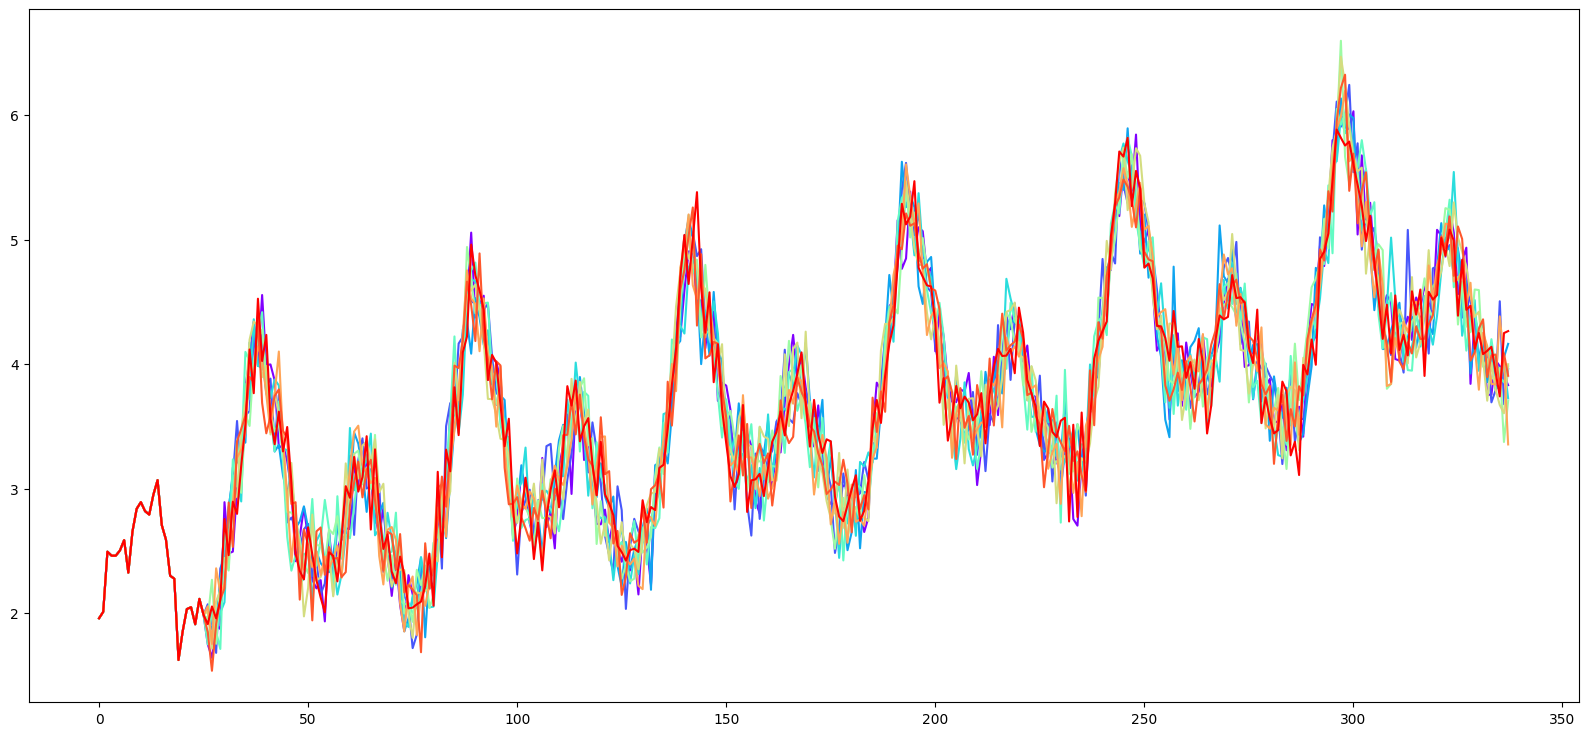

In [7]:
agents_RL = regime_change_detection_RLKF(trained_BDLM = BDLM, val_datetime_values = val_datetime_values)
agents_RL.generate_synthetic_ts(num_syn_ts = 200, syn_ts_len = hyperparameters['kernel']['period'] * 6)
agents_RL.save_synthetic_ts(datetime_save_path='data/synthetic_ts/RLDS_syn_datetime_200episodes.csv',
                            observation_save_path='data/synthetic_ts/RLDS_syn_observation_200episodes.csv')